## Problem Statement:

Credit card fraudulent issue is gaining more and more attention nowadays due to an increasing popularity in digital and online purchases. It is important that credit card companies are able to recognize fraudulent credit card transactions so that customers are not charged for items that they did not purchase. However, credit card or other financial institutions can not share their transaction information easily with the public due to customer privacy protection policies. Alternatively, synthetic transaction data can be generated from real-world data using a simulation approach, which highly mimics the patterns and characteristics of the real data in order for credit card fraud detection research and analysis. 

The dataset comes from https://www.kaggle.com/ntnu-testimon/paysim1

The objectives are to: <br> 
1) explore within each parameter, and examine for statistical correlations among different parameters and review the distribution patterns; <br> 
2) extract a subset of data prior to data analysis to be used for prediction validation purpose; <br> 
3) use different machine learning algorithms to detect fraudulent transactions.<br> 


<a id='top'></a>

## Table of Contents: 
### 1. <a href='#import'>Import Data</a>
### 2. <a href='#EDA'>Exploratory Data Analysis</a>
21. <a href='#2.1'>Fraudulent transaction percentage</a><br>
22. <a href='#2.2'>Distribution pattern of each variable</a><br>
23. <a href='#2.3'>Percentage of fraudulent transaction in each transaction type</a><br>
24. <a href='#2.4'>Transaction amount</a><br>
25. <a href='#2.5'>Time of Fraudulent Transaction</a><br>
    2.5.1 <a href='#2.5.1'>Feature Engineering 1 : Create day and hour feature</a><br>
    2.5.2 <a href='#2.5.2'>On what days do fraud transaction occur the most?</a><br>
    2.5.3 <a href='#2.5.3'>At what times of the day do fraud transaction occur the most?</a><br>
26. <a href='#2.6'>Can we pinpoint the accounts with more frequent fraud transactions?</a><br>
27. <a href='#2.7'>How well does the Flag feature predict the fraudulent transactions, can we rely on it?</a><br>

### 3. <a href='#3.0'>Feature-engineering</a>
31. <a href='#3.1'>Create dummy variables for transaction type: 1 for cash out and 0 for transfer</a>

### 4. <a href='#4.0'>Machine Learning</a>
41. <a href='#4.1'>Exploratory Machine Learning Algorithm Analysis without Hyperparameter Tuning</a><br>
    4.1.1 <a href='#4.1.1'>Logistic Regression</a><br>
    4.1.2 <a href='#4.1.2'>K Neighbors Classifier</a><br>
    4.1.3 <a href='#4.1.3'>Decision Tree</a><br>
    4.1.4 <a href='#4.1.4'>Random Forest Classifier</a><br>
    4.1.5 <a href='#4.1.5'>Gradient Boosting Classifier</a><br>
42. <a href='#4.2'>Feature importance based on RandomForest Classifier model</a><br>
43. <a href='#4.3'>Visualize Decision Boundaries of the Random Forest Classifier</a><br>

### 5. <a href='#5.0'>Conclusions</a>

<a id='import'></a>
# 1. Import data

In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
from sklearn.model_selection import cross_validate, ShuffleSplit, GridSearchCV
from sklearn.linear_model import LogisticRegressionCV
from sklearn import ensemble, naive_bayes, svm, tree, discriminant_analysis, neighbors, feature_selection
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
## Decision boundary plots
import matplotlib.patches as mpatches
from mlxtend.plotting import plot_decision_regions
import scipy.stats as stats
from xgboost.sklearn import XGBClassifier
from xgboost import plot_importance, to_graphviz

In [2]:
data=pd.read_csv('creditcard.csv')
print(data.head(5))

   step      type    amount     nameOrig  oldbalanceOrg  newbalanceOrig  \
0     1   PAYMENT   9839.64  C1231006815       170136.0       160296.36   
1     1   PAYMENT   1864.28  C1666544295        21249.0        19384.72   
2     1  TRANSFER    181.00  C1305486145          181.0            0.00   
3     1  CASH_OUT    181.00   C840083671          181.0            0.00   
4     1   PAYMENT  11668.14  C2048537720        41554.0        29885.86   

      nameDest  oldbalanceDest  newbalanceDest  isFraud  isFlaggedFraud  
0  M1979787155             0.0             0.0        0               0  
1  M2044282225             0.0             0.0        0               0  
2   C553264065             0.0             0.0        1               0  
3    C38997010         21182.0             0.0        1               0  
4  M1230701703             0.0             0.0        0               0  


In [3]:
print(data.shape)
print(data.columns)
print(data.info())

(6362620, 11)
Index(['step', 'type', 'amount', 'nameOrig', 'oldbalanceOrg', 'newbalanceOrig',
       'nameDest', 'oldbalanceDest', 'newbalanceDest', 'isFraud',
       'isFlaggedFraud'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
step              int64
type              object
amount            float64
nameOrig          object
oldbalanceOrg     float64
newbalanceOrig    float64
nameDest          object
oldbalanceDest    float64
newbalanceDest    float64
isFraud           int64
isFlaggedFraud    int64
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB
None


In [4]:
## Assert that there is no missing value and all numeric variables are above 0:
assert pd.notnull(data).all().all()
assert (data[['step','amount','oldbalanceOrg','newbalanceOrig','oldbalanceDest','newbalanceDest','isFraud','isFlaggedFraud']]>=0).all().all()

It looks like from the quick check, there is no missing(null) in the dataset and all the numeric variables are >=0.

<a id='EDA'></a>
# 2. Exploratory Data Analysis

<a id='2.1'></a>
## 2.1 Fraudulent transaction percentage

In [5]:
fraudcount=data.isFraud[data.isFraud==1].count()
totalcount=len(data)
percentfraud=fraudcount/totalcount
print('The percentage of fraudulent transaction is {0:.5f} %'.format(percentfraud*100))


The percentage of fraudulent transaction is 0.12908 %


<a id='2.2'></a>
## 2.2 Distribution pattern of each variable

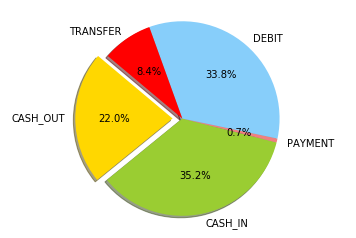

In [6]:
labels = set(data['type'])
sizes = data.groupby('type').count()
colors = ['gold', 'yellowgreen', 'lightcoral', 'lightskyblue','red']
explode = (0.1, 0, 0, 0, 0)  # explode 1st slice

# Plot
plt.pie(sizes['step'], explode=explode, labels=labels, colors=colors,
autopct='%1.1f%%', shadow=True, startangle=140)

plt.axis('equal')
plt.show()

Transaction amount

It looks like the majority of the transactions are money transfer, cash deposit and payment, which count for over 90% of the total number of transactions.

<a id='2.3'></a>
## 2.3 Percentage of fraudulent transaction in each transaction type

In [7]:
fraudsizes = data[data.isFraud==1].groupby('type').count()
fraudsizes.isFraud

type
CASH_OUT    4116
TRANSFER    4097
Name: isFraud, dtype: int64

Fraudulent transactions only exist in cashout and money transfer type of transactions.

In [8]:
cashcount=len(data[data.type=='CASH_OUT'])
transcount=len(data[data.type=='TRANSFER'])
fraudcash=fraudsizes.step.CASH_OUT/cashcount

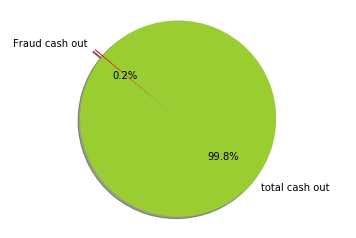

In [9]:
colors = ['red', 'yellowgreen']
explode=(0.1, 0) 
# Plot
plt.pie([fraudsizes.step.CASH_OUT,cashcount], explode=explode, labels=['Fraud cash out','total cash out'], colors=colors,
autopct='%1.1f%%', shadow=True, startangle=140)

plt.axis('equal')
plt.show()

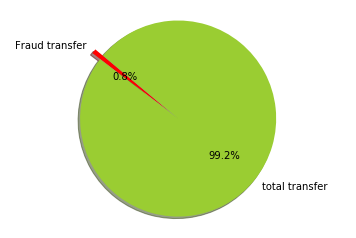

In [10]:
colors = ['red', 'yellowgreen']
explode=(0.1, 0) 
# Plot
plt.pie([fraudsizes.step.TRANSFER,transcount], explode=explode, labels=['Fraud transfer','total transfer'], colors=colors,
autopct='%1.1f%%', shadow=True, startangle=140)

plt.axis('equal')
plt.show()

Approximately 0.2% of the total cash out transactions are fraudulent and approximately 0.8% of the total transfer transactions are fraudulent.

<a id='2.4'></a>
## 2.4 Transaction amount

In [11]:
# Is there any $0 transaction in the dataset?
data[data.amount==0]

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
2736447,212,CASH_OUT,0.0,C1510987794,0.0,0.0,C1696624817,0.00,0.00,1,0
3247298,250,CASH_OUT,0.0,C521393327,0.0,0.0,C480398193,0.00,0.00,1,0
3760289,279,CASH_OUT,0.0,C539112012,0.0,0.0,C1106468520,538547.63,538547.63,1,0
5563714,387,CASH_OUT,0.0,C1294472700,0.0,0.0,C1325541393,7970766.57,7970766.57,1,0
5996408,425,CASH_OUT,0.0,C832555372,0.0,0.0,C1462759334,76759.90,76759.90,1,0
5996410,425,CASH_OUT,0.0,C69493310,0.0,0.0,C719711728,2921531.34,2921531.34,1,0
6168500,554,CASH_OUT,0.0,C10965156,0.0,0.0,C1493336195,230289.66,230289.66,1,0
6205440,586,CASH_OUT,0.0,C1303719003,0.0,0.0,C900608348,1328472.86,1328472.86,1,0
6266414,617,CASH_OUT,0.0,C1971175979,0.0,0.0,C1352345416,0.00,0.00,1,0
6281483,646,CASH_OUT,0.0,C2060908932,0.0,0.0,C1587892888,0.00,0.00,1,0


In [12]:
print('The number of $0 transaction is {}'.format(len(data[data.amount==0])))

The number of $0 transaction is 16


According to the above table, there are $0 transactions and all of them are cashout transactions. It is likely that the bank suspected the fraudulent cashout activity and suspended the cashout transaction in time. Now lets' remove these attempted fraudulent transactions and check if there is any pattern in overall transaction amounts and fraudulent ones. 

Text(0.5,1,'Distribution of all transaction amount')

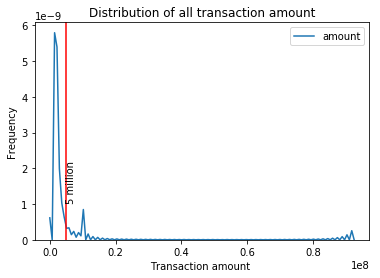

In [13]:
dist = sns.kdeplot(data.amount[data.amount!=0])
dist.set_xlabel("Transaction amount ")
dist.set_ylabel("Frequency")
plt.axvline(x=5000000 ,color='r')
plt.text(5000000,0.000000002,'5 million',rotation=90)
plt.title('Distribution of all transaction amount')

The transaction amounts span a wide range from 0 to nearly 90 million, however, most of the transactions are within 5 million.

Text(0.5,1,'Distribution of fraudulent transaction amount')

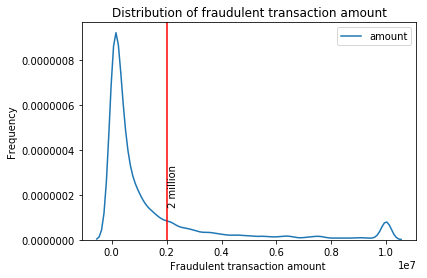

In [14]:
dist = sns.kdeplot(data.amount[data.isFraud==1][data.amount!=0])
dist.set_xlabel("Fraudulent transaction amount ")
dist.set_ylabel("Frequency")
plt.axvline(x=2000000 ,color='r')
plt.text(2050000,0.0000003,'2 million',rotation=90)
plt.title('Distribution of fraudulent transaction amount')

The fraudulent transaction amounts range from 0 to nearly 10 million, however, most of the fraudulent transactions are within 2 million.

In [15]:
ave_trans=data.amount[data.isFraud==0][data.amount!=0].mean()
ave_fraud=data.amount[data.isFraud==1][data.amount!=0].mean()
print('The average overall transaction amount is {0:,.2f}.' .format(ave_trans))
print('The average fraud transaction amount is {0:,.2f}.' .format(ave_fraud))

The average overall transaction amount is 178,197.04.
The average fraud transaction amount is 1,470,832.67.


The average fraudulent transaction is much higher (8 times higher) than the average overall transaction amounts: 1,470k vs 178k.

<a id='2.5'></a>
## 2.5 Time of Fraudulent Transaction

The step column in the data represents the time of the transaction during a 30 day period. One step represents one hour. The step needs to be converted to datetime before analysis.

<a id='2.5.1'></a>
### Feature Engineering 1 : Create day and hour feature

In [16]:
days=[]
hours=[]
for x in data.step:
    day=np.floor(x/24)
    hour=x-day*24
    days.append(day)
    hours.append(hour)

In [17]:
data['day']=days
data['hour']=hours
print(data.head())

   step      type    amount     nameOrig  oldbalanceOrg  newbalanceOrig  \
0     1   PAYMENT   9839.64  C1231006815       170136.0       160296.36   
1     1   PAYMENT   1864.28  C1666544295        21249.0        19384.72   
2     1  TRANSFER    181.00  C1305486145          181.0            0.00   
3     1  CASH_OUT    181.00   C840083671          181.0            0.00   
4     1   PAYMENT  11668.14  C2048537720        41554.0        29885.86   

      nameDest  oldbalanceDest  newbalanceDest  isFraud  isFlaggedFraud  day  \
0  M1979787155             0.0             0.0        0               0  0.0   
1  M2044282225             0.0             0.0        0               0  0.0   
2   C553264065             0.0             0.0        1               0  0.0   
3    C38997010         21182.0             0.0        1               0  0.0   
4  M1230701703             0.0             0.0        0               0  0.0   

   hour  
0   1.0  
1   1.0  
2   1.0  
3   1.0  
4   1.0  


<a id='2.5.2'></a>
### On what days do fraud transaction occur the most?

Text(0,0.5,'Amounts of fraud transactions during each day')

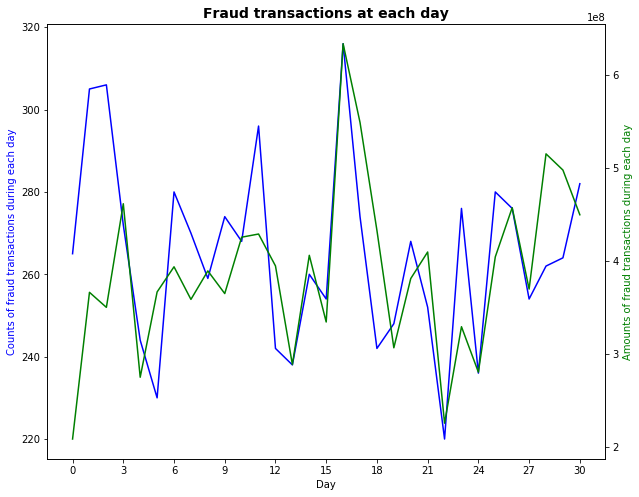

In [18]:
fig = plt.figure(figsize=(10, 8))
ax = plt.axes()
ax.plot(data[data.isFraud==1].groupby('day').type.count(), color='blue')
plt.ylabel('Counts of fraud transactions during each day',color='blue')
plt.xlabel('Day')
plt.xticks(np.arange(0,31,3))
ax.set_title('Fraud transactions at each day',fontweight='bold',fontsize=14,)
ax2 = ax.twinx()
ax2.plot(data[data.isFraud==1].groupby('day').amount.sum(), color='green')
ax2.set_ylabel('Amounts of fraud transactions during each day',color='green')


Based on the above plot: 
1. the fraud transaction amounts geenrally match the counts of fraud transactions at each day; 
2. there is a spike of fraud transactions at day 17, middle of the month. We do not know exactly which day of the week it falls into, but this spike pattern may raise some caution.

<a id='2.5.3'></a>
### At what times of the day do fraud transaction occur the most?

Text(0,0.5,'Amounts of fraud transactions during different hours')

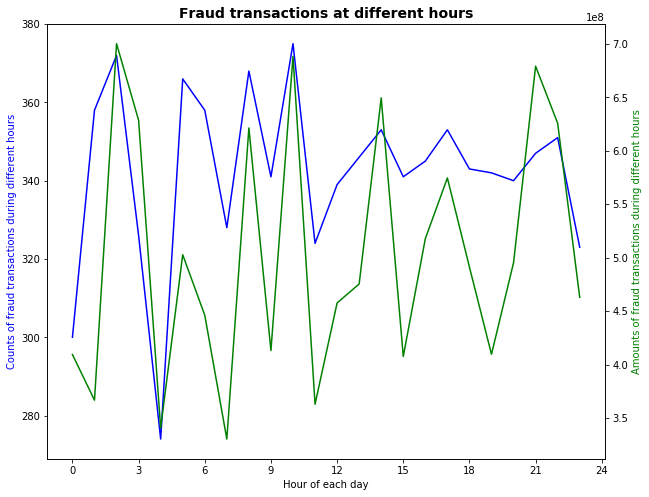

In [19]:
fig = plt.figure(figsize=(10, 8))
ax = plt.axes()
ax.plot(data[data.isFraud==1].groupby('hour').type.count(), color='blue')
plt.ylabel('Counts of fraud transactions during different hours',color='blue')
plt.xlabel('Hour of each day')
plt.xticks(np.arange(0,25,3))
ax.set_title('Fraud transactions at different hours',fontweight='bold',fontsize=14,)
ax2 = ax.twinx()
ax2.plot(data[data.isFraud==1].groupby('hour').amount.sum(), color='green')
ax2.set_ylabel('Amounts of fraud transactions during different hours',color='green')


Based on the above plot: 
1. The fraud transactions occur more frequenly during the morning of the day, from 1 am to 11 am. 
2. The mount of fraud transactions are higher between early morning: 6 to 11 am and late nights: 7pm to 3 am.

<a id='2.6'></a>
## 2.6 Can we pinpoint the accounts with more frequent fraud transactions

In [20]:
name, counts = np.unique(data.loc[data.isFraud==1].nameOrig, return_counts=True)
fraudnames= pd.DataFrame(list(zip(name,counts)), columns=['Origname','counts'])
fraudnames.sort_values(by=['counts']).head()

,Origname,counts
0,C1000036340,1
5483,C356781229,1
5482,C356706674,1
5481,C356571967,1
5480,C356480504,1


No more than two fraud transactions were observed for any account during this 31 day period.

<a id='2.7'></a>
## 2.7 How well does the Flag feature predict the fraudulent transactions, can we rely on it?

In [21]:
from sklearn.metrics import accuracy_score
score=accuracy_score(data['isFraud'], data['isFlaggedFraud'])
print('Accuracy Score is {0:,.4f}.' .format(score))

Accuracy Score is 0.9987.


In [22]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
print('The confusion matrix is listed below:')
print(confusion_matrix(data['isFraud'], data['isFlaggedFraud']))


The confusion matrix is listed below:
[[6354407       0]
 [   8197      16]]


In [23]:
print('The classification report is listed below:')
print(classification_report(data['isFraud'], data['isFlaggedFraud']))

The classification report is listed below:
             precision    recall  f1-score   support

          0       1.00      1.00      1.00   6354407
          1       1.00      0.00      0.00      8213

avg / total       1.00      1.00      1.00   6362620



Conclusions on Flag parameters:

1. As we can see from the matrix and classification report, the Flag parameter does not identify the fraudulent transactions well: out of 8213 fraud transactions, it only flagged 16 transactions. 
2. Based on the description of the dataset, the flag is merely set for transactions of the amount over 200,000. According to our previous analysis, most of the transactions and fraud transactions are with the amount over 2 million. Therefore, this 200,000 trigger is not relavent or useful for fraud indication.
3. Since the success/positive rate from this Flag is extremely low, we should disgard this Flag parameter in our future analysis.

<a id='3.0'></a>
# 3. Feature-engineering

According to previous observation on the data table, some transactions have the transaction amount >0 while both its origin and destination balance being 0. This type of transaction seems more suspicious of being fraudulent than the other. We will evaluate whether this type of transaction has higher fraudulent percentage than overall transactions.

Since the fraudulent transaction only occurs in cash out and transfer type of transactions, we will only use these two types of transactions for fraud detection analysis.

<a id='3.1'></a>
## 3.1 Create dummy variables for transaction type: 1 for cash out and 0 for transfer.

In [24]:
data.loc[data.type == 'TRANSFER', 'type'] = 0
data.loc[data.type == 'CASH_OUT', 'type'] = 1
newdata=data.loc[(data.type == 0) | (data.type == 1)]
newdata['type'] = newdata['type'].astype(int)

In [25]:
frauddata = newdata.loc[newdata.isFraud == 1]
nonfrauddata = newdata.loc[newdata.isFraud == 0]

In [26]:
print('\nThe fraction of fraudulent transactions with \'oldBalanceDest\' = \
\'newBalanceDest\' = 0 although the transacted \'amount\' is non-zero is: {0:.5f} % '.\
format(len(frauddata.loc[(frauddata.oldbalanceDest == 0) & \
(frauddata.newbalanceDest == 0) & (frauddata.amount)]) / (1.0 * len(frauddata))*100))


The fraction of fraudulent transactions with 'oldBalanceDest' = 'newBalanceDest' = 0 although the transacted 'amount' is non-zero is: 49.55558 % 


In [27]:
print('\nThe fraction of legit transactions with \'oldBalanceDest\' = \
newBalanceDest\' = 0 although the transacted \'amount\' is non-zero is: {0:.5f} % '.\
format(len(nonfrauddata.loc[(nonfrauddata.oldbalanceDest == 0) & \
(nonfrauddata.newbalanceDest == 0) & (nonfrauddata.amount)]) / (1.0 * len(nonfrauddata))*100))


The fraction of legit transactions with 'oldBalanceDest' = newBalanceDest' = 0 although the transacted 'amount' is non-zero is: 0.06176 % 


As we can see that the questionable transactions (with amount >0 but both origin and destination balance being 0) account for nearly 50% of the total fraudulent transactions. However, this type of questionable transaction only accounts for 0.06% of the legit transactions.

Accordingly, we can introduce new features that help indicate these questionable transactions, as origflag and destflag:

In [28]:
newdata['origflag']=newdata.newbalanceOrig + newdata.amount - newdata.oldbalanceOrg
newdata['destflag']= newdata.oldbalanceDest + newdata.amount - newdata.newbalanceDest

<a id='4.0'></a>
# 4. Machine Learning

In [29]:
print(newdata.head())

    step  type     amount     nameOrig  oldbalanceOrg  newbalanceOrig  \
2      1     0     181.00  C1305486145          181.0             0.0   
3      1     1     181.00   C840083671          181.0             0.0   
15     1     1  229133.94   C905080434        15325.0             0.0   
19     1     0  215310.30  C1670993182          705.0             0.0   
24     1     0  311685.89  C1984094095        10835.0             0.0   

       nameDest  oldbalanceDest  newbalanceDest  isFraud  isFlaggedFraud  day  \
2    C553264065             0.0            0.00        1               0  0.0   
3     C38997010         21182.0            0.00        1               0  0.0   
15   C476402209          5083.0        51513.44        0               0  0.0   
19  C1100439041         22425.0            0.00        0               0  0.0   
24   C932583850          6267.0      2719172.89        0               0  0.0   

    hour   origflag   destflag  
2    1.0       0.00      181.0  
3    1.0

Based on our previous analysis, several feature modifications will be made and applied in the ML analysis.

1. Features such as nameOrig and namedest are both unique for each transaction. Therefore, they are completely independent from the isFraud target feature. We can drop these two feature out for the ML modeling. 


2. The step feature can also be dropped out because the original step feature is an accumulative time feature, which does not intuitively correlate with the occurance of fraud transactions. Instead, two new features: day and hour, are created and will be used in the ML analysis.

<a id='4.1'></a>
## 4.1 Exploratory Machine Learning Algorithm Analysis without Hyperparameter Tuning

<a id='4.1.1'></a>
###      LogisticRegressionCV

In [30]:
X = newdata[['step','type','amount','oldbalanceOrg','newbalanceOrig','oldbalanceDest','newbalanceDest','day','hour','origflag','destflag']]
y = newdata.isFraud

# Create training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=41)

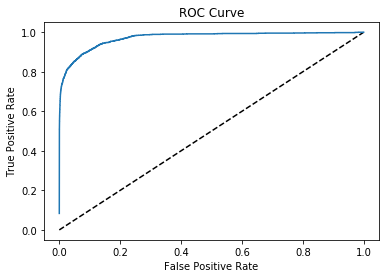

The confusion matrix for the LogisticRegressionCV model is listed below:
[[552337    164]
 [   791    790]]
The ROC score for the LogisticRegressionCV model is 0.75  


In [31]:


model1=LogisticRegressionCV()
model1.fit(X_train, y_train)
y_pred = model1.predict(X_test)

# Compute predicted probabilities for positive classification: y_pred_prob
y_pred_prob = model1.predict_proba(X_test)[:,1]

# Generate ROC curve values: fpr, tpr, thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

# Plot ROC curve
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

print('The confusion matrix for the LogisticRegressionCV model is listed below:')
print(confusion_matrix(y_test, y_pred))
print( 'The ROC score for the LogisticRegressionCV model is {0:.2f}  '.format(roc_auc_score(y_test, y_pred)))

In [31]:
cv_split = ShuffleSplit(n_splits = 5, test_size = .2, train_size = .8, random_state = 40)
cv_results = cross_validate(model1, X,y, cv  = cv_split, return_train_score=True)
print( 'The training accuracy score for the LogisticRegressionCV model is {0:.4f}'.format(cv_results['train_score'].mean()))
print('The testing accuracy score for the LogisticRegressionCV model is {0:.4f}'.format(cv_results['test_score'].mean()))

The training accuracy score for the LogisticRegressionCV model is 0.9983
The testing accuracy score for the LogisticRegressionCV model is 0.9983


<a id='4.1.2'></a>
###       K Neighbors Classifier

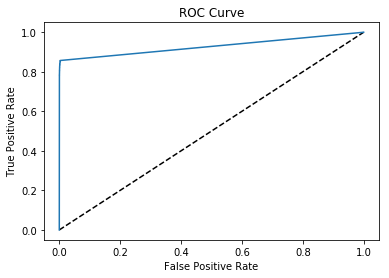

The confusion matrix for K Neighbors Classifier is listed below:
[[552342    159]
 [   368   1213]]
The ROC score for the Support K Neighbors Classifier is 0.88 


In [32]:
model3=neighbors.KNeighborsClassifier(weights='distance')
model3.fit(X_train, y_train)
y_pred3 = model3.predict(X_test)

# Compute predicted probabilities for positive classification: y_pred_prob
y_pred_prob3 = model3.predict_proba(X_test)[:,1]

# Generate ROC curve values: fpr, tpr, thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob3)

# Plot ROC curve
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

print('The confusion matrix for K Neighbors Classifier is listed below:')
print(confusion_matrix(y_test, y_pred3))
print( 'The ROC score for the K Neighbors Classifier is {0:.2f} '.format(roc_auc_score(y_test, y_pred3)))


<a id='4.1.3'></a>
###       Decision Tree

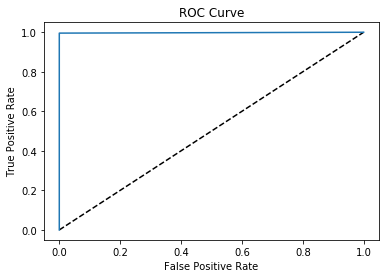

The confusion matrix for Decision Tree Classifier is listed below:
[[552494      7]
 [     7   1574]]
The ROC score for Decision Tree Classifier is 1.00 


In [32]:
model4=tree.DecisionTreeClassifier()
model4.fit(X_train, y_train)
y_pred4 = model4.predict(X_test)

# Compute predicted probabilities for positive classification: y_pred_prob
y_pred_prob4 = model4.predict_proba(X_test)[:,1]

# Generate ROC curve values: fpr, tpr, thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob4)

# Plot ROC curve
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

print('The confusion matrix for Decision Tree Classifier is listed below:')
print(confusion_matrix(y_test, y_pred4))
print( 'The ROC score for Decision Tree Classifier is {0:.2f} '.format(roc_auc_score(y_test, y_pred4)))


<a id='4.1.4'></a>
###         Random Forest Classifier

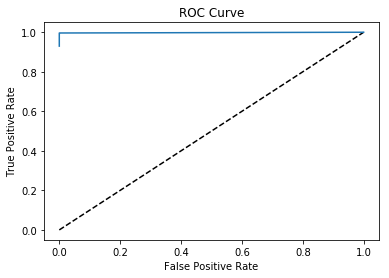

The confusion matrix for Random Forest Classifier is listed below:
[[552501      0]
 [     8   1573]]
The ROC score for Random Forest Classifier is 1.00 


In [33]:

model7=ensemble.RandomForestClassifier()
model7.fit(X_train, y_train)
y_pred7 = model7.predict(X_test)

# Compute predicted probabilities for positive classification: y_pred_prob
y_pred_prob7 = model7.predict_proba(X_test)[:,1]

# Generate ROC curve values: fpr, tpr, thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob7)

# Plot ROC curve
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

print('The confusion matrix for Random Forest Classifier is listed below:')
print(confusion_matrix(y_test, y_pred7))
print( 'The ROC score for Random Forest Classifier is {0:.2f} '.format(roc_auc_score(y_test, y_pred7)))


<a id='4.1.5'></a>
###            Gradient Boosting Classifier

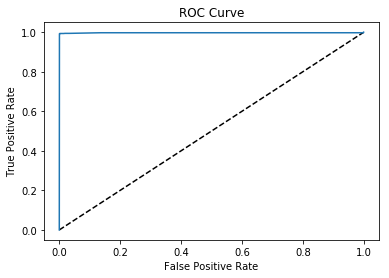

The confusion matrix for Gradient Boosting Classifier is listed below:
[[552283    218]
 [    12   1569]]
The ROC score for Gradient Boosting Classifier is 1.00 


In [34]:

model6=ensemble.GradientBoostingClassifier()
model6.fit(X_train, y_train)
y_pred6 = model6.predict(X_test)

# Compute predicted probabilities for positive classification: y_pred_prob
y_pred_prob6 = model6.predict_proba(X_test)[:,1]

# Generate ROC curve values: fpr, tpr, thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob6)

# Plot ROC curve
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

print('The confusion matrix for Gradient Boosting Classifier is listed below:')
print(confusion_matrix(y_test, y_pred6))
print( 'The ROC score for Gradient Boosting Classifier is {0:.2f} '.format(roc_auc_score(y_test, y_pred6)))


Based on the above plots, we can conclude that all five ML models inclduing LogisticRegressionCV, Gradient Boosting Classifier, Random Forest Classifier, Decision Tree and K Neighbors Classifier did very good job (all ROC scores close to 1) at identifying the fraudulent transaction: especially the Random Forest Classifier with 100% accuracy for class 0 transactions (non-fraud), and 1573 out of 1581 accurate identification for class 1 (fraud) transactions.  

The Random Forest Classifier already does an awesome job at the prediction and parameter hypertuning is thus not considered given the already superior performance. Next, we will evaluate the feature importance in the RandomForest Classifier model.

<a id='4.2'></a>
##  4.2 Feature importance based on RandomForest Classifier model

In [35]:
def plot_feature_importances(df):
    
    # Sort features according to importance
    df = df.sort_values('importance', ascending = False).reset_index()
    
    # Normalize the feature importances to add up to one
    df['importance_normalized'] = df['importance'] / df['importance'].sum()

    # Make a horizontal bar chart of feature importances
    plt.figure(figsize = (10, 6))
    ax = plt.subplot()
    
    # Need to reverse the index to plot most important on top
    ax.barh(list(reversed(list(df.index[:15]))), 
            df['importance_normalized'].head(15), 
            align = 'center', edgecolor = 'k')
    
    # Set the yticks and labels
    ax.set_yticks(list(reversed(list(df.index[:15]))))
    ax.set_yticklabels(df['feature'].head(15))
   
    # Plot labeling
    plt.xlabel('Normalized Importance'); plt.title('Feature Importances by RandomForest Classifier')
    plt.show()
    
    return df

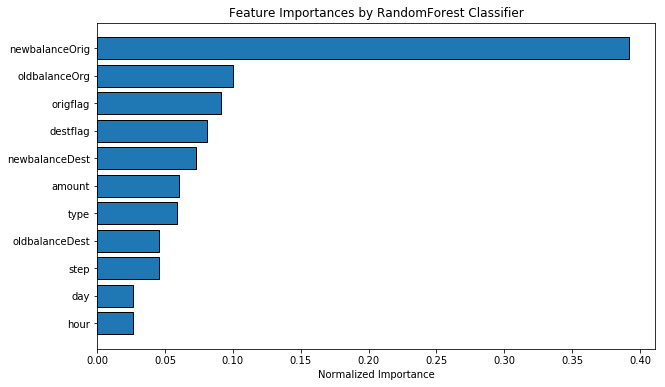

In [36]:
importance = model7.feature_importances_
feature = X.columns
fi = pd.DataFrame()
fi['importance'] = importance
fi['feature'] = feature
fi_sorted = plot_feature_importances(fi)

Based on the feature importance plot, the new balance from original transaction account is the most critical feature in predicting fraudulent transaction (close to 40% of all 11 features), followed by old blance in the original account, newly engineered features: original flag and destination flag, which represent the attemped transactions from origin to destination accounts when both account have 0 balance. 

<a id='4.3'></a>
## 4.3 Visualize Decision Boundaries of the Random Forest Classifier.

In [38]:
### Helper functions for plotting
# A function to plot observations on scatterplot
def plotcases(ax):
    plt.scatter(X_train['newbalanceOrig'],X_train['oldbalanceOrg'],c=y_train,  axes=ax, alpha=0.6, s=20, lw=0.4)
    ax.tick_params(axis='both', which='both')

# a function to draw decision boundary and colour the regions
def plotboundary(ax, Z):
    ax.pcolormesh(xx, yy, Z,alpha=0.3)  
    ax.contour(xx, yy, Z, [0.5], linewidths=0.75, colors='k')

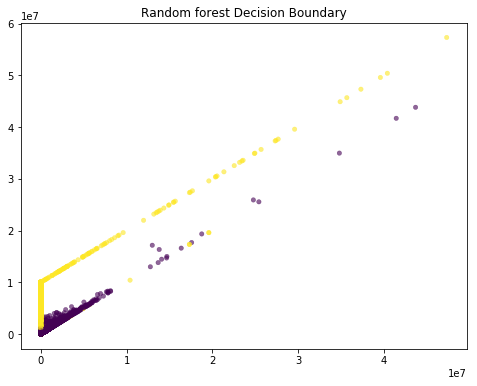

In [47]:
### Generate data

rf = ensemble.RandomForestClassifier()
rf.fit(X_train[['newbalanceOrig','oldbalanceOrg']], y_train)


fig = plt.figure(figsize=(8,6)) 
# take boundaries from first plot and define mesh of points for plotting decision spaces
x_min, x_max = plt.xlim()
y_min, y_max = plt.ylim()
nx, ny = 100, 100   # this sets the num of points in the mesh
xx, yy = np.meshgrid(np.linspace(x_min, x_max, nx),
                     np.linspace(y_min, y_max, ny))

Z = rf.predict_proba(np.c_[xx.ravel(), yy.ravel()])
Z = Z[:,1].reshape(xx.shape)
ax = plt.axes()
ax.title.set_text("Random forest Decision Boundary")
plotboundary(ax, Z)
plotcases(ax)

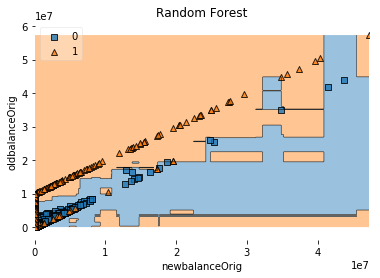

In [41]:
# Plotting decision regions
plot_decision_regions(X_train[['newbalanceOrig','oldbalanceOrg']].values, y_train.values, clf=rf, legend=2)

# Adding axes annotations
plt.xlabel('newbalanceOrig')
plt.ylabel('oldbalanceOrig')
plt.title('Random Forest')
plt.show()

The above decision boundary is based on the random forest model and is plotted using only the newbalanaceOrig and oldbalanceOrig features of the data. The decision boundary already does a very good job seperating out fraud and non-fraud transactions.

<a id='5.0'></a>
# 5. Conclusions

1. Through exploratory data analysis, we identified that fraud transactions only occur in cash out and transfer type of transactions. <br>
<br>
2. Several original features such as nameOrig and nameDest do not correlate with the occurence of fraud transactions and they are removed for further analysis. The original fraud flag freature does a poor job at positively identifying fraud transactions and this feature is further removed for ML modeling.<br>
<br>
3. We identified suspicious transaction pattern in the dataset, where the transaction amount is >0 but both its origin and destination account balance are 0. This type of transactions account for close to 50% of the overall fraudulent transactions and account for only 0.06% of the legit transactions. <br>
<br>
4. Several engineered features are created including day and hour of the transactions.  Two other new features are also created to identify the suspicious transactions mentioned above: one for the origin account and another for the destination account. These two features generate outstanding balances in both origin and destination accounts that could not be transafered due to the 0 balance in the origin account, or a 0 balance for origin accounts that have sufficient balance for transfer.<br>
<br>
5. Five ML models (LogisticRegressionCV, Gradient Boosting Classifier, Random Forest Classifier, Decision Tree and K Neighbors Classifier) have been tested on the modified dataset and all of them give good predictions of the fraud transactions. Random Forest Classifier gives the best performance with a ROC score being very close to 1: 100% ture negative rate, 0 false positive rate, 0.5% false negative rate and 99.5% true positive rate.<br>
<br>
6. The most critical features in fraud transaction prediction by random forest model include the new and old blance in the origin account, newly engineered features including flagged amounts during suspicious transactions in origin and destination accounts.